In [2]:
import os
import numpy as np
import time
#import pickle
%matplotlib inline
from matplotlib import pyplot as plt
#import seaborn as sns
from skimage.filters import sobel_h, sobel_v
from skimage.color import rgb2grey
from skimage.transform import resize
from skimage.filters import threshold_adaptive
from skimage.exposure import rescale_intensity
from skimage.measure import compare_ssim, compare_psnr

from utils.utils import *
from utils.iterators import SynthiaIterator, FreiburgIterator, TUMIterator
from utils.associate import associate, read_file_list

from time import time

from itertools import product

import tensorflow as tf
from tensorflow.contrib import layers as l
import cv2
from sklearn.metrics import mean_squared_error

import h5py
from PIL import Image

import read_depth

from models import SR_model
from models import interpolation_model

D:\Python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def remove_zeros(d):
    mask = np.isinf(d)
    min_d = d.min()
    max_d = d[np.logical_not(mask)].max()
    d = (d - min_d) / (max_d - min_d) * 255
    d[mask] = np.zeros_like(d)[mask]
    idx = np.where(d == 0)
    d_b = cv2.medianBlur(d.astype(np.uint8), 155)
    d[idx] = d_b[idx]
    d = d.astype(np.float32) * (max_d - min_d) + min_d
    return d[...,None]

def normalize(disp):
    depth = disp.astype(float)
    depth = ((depth - depth.min()) / (depth.max() - depth.min() + 1))*2.1
    return depth


    
    

In [4]:
def combined_mask(img, sz, combined=True, block_size = 5, constant = 11 ):
    import cv2
    resized = cv2.resize(img.astype(np.uint8), tuple(sz[::-1]))
    blurred = cv2.GaussianBlur(resized, (5, 5), 0.2)
    grey = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
    grad_x = cv2.Sobel(grey, cv2.CV_16S, 1, 0).astype(float)
    grad_y = cv2.Sobel(grey, cv2.CV_16S, 0, 1).astype(float)
    grad = np.sqrt(np.square(grad_x) + np.square(grad_y))
    grad = np.round((grad - grad.min())/(grad.max() - grad.min())*255).astype(np.uint8)
    grad_thr = cv2.adaptiveThreshold(grad,np.max(grad),cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, constant)
    grad_thr = (grad_thr - grad_thr.min())/(grad_thr.max() - grad_thr.min())
    grad_thr = np.ones(grad_thr.shape, dtype=np.float32) - grad_thr.astype(np.float32) 
    random = np.random.choice([0, 1],size=sz, p=[1 - 0.05, 0.05])
    if combined:
        grad_thr = np.clip(grad_thr + random, 0, 1)
    else:
        grad_thr = np.clip(grad_thr, 0, 1)
    return grad_thr.astype(int)[None, :, :, None]


def get_grad_mask(img, sz,combined=True, block_size = 5, constant = 11 ):
    shape = img.shape
    bs = img.shape[0]
    return np.concatenate([combined_mask(img[i,:,:,:], sz, combined,block_size, constant) for i in range(bs)])

def get_mask(sz, p):
    mask = np.random.choice([0,1],size=sz, p=[1 - p, p])[None,:,:,None]
    return mask

def get_regular_grid_mask(sz, step = 7):
    z = np.zeros((1, *sz, 1))
    z[:,::step,::step,:] = 1
    return z

def resize_batch(xb,yb,bs, small_size):
    newx = np.concatenate([cv2.resize(xb[i,:,:,:], tuple(reversed(small_size)))[None,...] for i in range(bs)])
    newy = np.concatenate([cv2.resize(yb[i,:,:,:], tuple(reversed(small_size)))[None,...,None] for i in range(bs)])
    return newx,newy

def crop_batch_NYU(xb,yb,bs, crop):
    h = int(crop[0]/2)
    w = int(crop[1]/2)
    newx = np.concatenate([xb[i,h:-h, w:-w,:][None,...] for i in range(bs)])
    newy = np.concatenate([yb[i,h:-h, w:-w,:][None,...] for i in range(bs)])
    return newx,newy

def rescale_depth(d, to0255 = True, d_min = None, d_max = None):# to 0-255 and uint8
    if to0255:
        return (255.0 / d.max() * (d - d.min())).astype(np.uint8), d.min(), d.max()
    else:
        return d/255.0 * d_max + d_min

def denoise_batch(yb, bs):
    temp = []
    for i in range(bs):
        d, d_min, d_max = rescale_depth(yb[i,:,:,:])
        #temp2 = cv2.fastNlMeansDenoising(d,None,7,7,21)
        temp2 = cv2.medianBlur(d, 7)
        #temp2 = cv2.bilateralFilter(d,45,45,45)
        temp.append(rescale_depth(temp2, False, d_min, d_max)[None,...,None])
    return np.concatenate(temp)

In [5]:
def predict(sess, G_output, G_output2, batch_d, batch_mask):
    predicted = sess.run(G_output, feed_dict={target: batch_d, mask_t: batch_mask, d_flg: False})
    #plt.matshow(predicted[0,:,:,0])
    #plt.figure()
    predicted_denoised = denoise_batch(predicted, len(batch_d))
    #plt.matshow(predicted_denoised[0,:,:,0])
    
    result = sess.run(G_output2, feed_dict={d_small:(predicted_denoised), d_flg:False})
    
    return predicted_denoised, (result)*2.1


def predict_sparse(sess, G_output, G_output2, batch_d):
    predicted = sess.run(G_output, feed_dict={sparse: batch_d, d_flg: False})
    #plt.matshow(predicted[0,:,:,0])
    #plt.figure()
    predicted_denoised = denoise_batch(predicted, len(batch_d))
    #plt.matshow(predicted_denoised[0,:,:,0])
    
    result = sess.run(G_output2, feed_dict={d_small:(predicted_denoised), d_flg:False})
    
    return predicted_denoised, (result)

In [6]:
def rmse(x, y):
    return np.sqrt(((x - y)*(x - y)).mean())
def psnr(disp, result):
    err = mean_squared_error(disp, result)
    return 20 * np.log(disp.max()/np.sqrt(err))/np.log(10)
def ssim(disp_big, result):
    compare_ssim(result.astype(float), disp_big.astype(float))
    
def norm_max(img):
    return (img - img.min())/(img.max() - img.min())

In [7]:
def plot_different_masks(disp, rgbim, original_size, on = True):
    grad_mask = get_grad_mask(rgbim[None,...], tuple(original_size), combined=True)
    grad_clean_mask = get_grad_mask(rgbim[None,...], tuple(original_size), combined=False)
    pr = 0.05
    random_mask = get_mask(tuple(original_size), pr)
    regular_mask = get_regular_grid_mask(tuple(original_size), step = 4)
    print('mask sizes = ', grad_mask.shape, random_mask.shape)
    
    fig, ax = plt.subplots(1,5,figsize = (20,20))
    if on:
        ax[0].matshow(disp), ax[0].set_title("original"), ax[0].axis('off')
        ax[1].matshow(grad_mask[0,:,:,0] * disp), ax[1].set_title("grad mask"), ax[1].axis('off')
        ax[2].matshow(grad_clean_mask[0,:,:,0] * disp), ax[2].set_title("grad mask w/o noise"), ax[2].axis('off')
        ax[3].matshow(random_mask[0,:,:,0] * disp), ax[3].set_title("random mask, p = %.2f" % pr), ax[3].axis('off')
        ax[4].matshow(regular_mask[0,:,:,0] * disp), ax[4].set_title("regular mask"), ax[4].axis('off')
    else:
        ax[0].matshow(disp), ax[0].set_title("original"), ax[0].axis('off')
        ax[1].matshow(grad_mask[0,:,:,0] ), ax[1].set_title("grad mask"), ax[1].axis('off')
        ax[2].matshow(grad_clean_mask[0,:,:,0] ), ax[2].set_title("grad mask w/o noise"), ax[2].axis('off')
        ax[3].matshow(random_mask[0,:,:,0] ), ax[3].set_title("random mask, p = %.2f" % pr), ax[3].axis('off')
        ax[4].matshow(regular_mask[0,:,:,0]), ax[4].set_title("regular mask"), ax[4].axis('off')

In [8]:
def save_depth(image, path_name = 'd.png'):
    predicted_rescaled = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
    Image.fromarray(predicted_rescaled).save(path_name, "PNG") 

def print_results(sess, G_output, G_output2,disp, disp_downsampled,mask, name = None, print_titles = True):
    predicted_interp, result = predict(sess, G_output, G_output2,disp_downsampled[None,...,None], mask)
    
    fig, ax = plt.subplots(1,5,figsize = (20,20))
    ax[0].matshow(cv2.resize(np.log(disp), tuple(reversed(big_size)))), ax[0].axis('off')
    ax[1].matshow(np.log(disp_downsampled)), ax[1].axis('off')
    ax[2].matshow(np.log(disp_downsampled)*mask[0,:,:,0]), ax[2].axis('off')
    ax[3].matshow(predicted_interp[0,:,:,0]), ax[3].axis('off')
    ax[4].matshow((result[0,:,:,0])), ax[4].axis('off')
    
    if print_titles:
        ax[0].set_title("ground truth")
        ax[1].set_title("downsampled ground truth")
        ax[2].set_title("depth masked")
        ax[3].set_title("interpolation output")
        ax[4].set_title("output")
    
    if name:
        save_depth(result[0,:,:,0], os.getcwd() + '/others/' + name)
        
    return predicted_interp, result

def resize_pair(rgb, depth, size):
    newrgb = cv2.resize(rgb, tuple(reversed(size)))
    newdepth = cv2.resize(depth,tuple(reversed(size)))#.astype( np.uint8)
    return newrgb, newdepth

In [17]:
#All paths are here
test_dataset = os.getcwd()+'/middlebury/art/'
saved_models = 'D:/Alice/Documents/deeplearning-semidense/out/'

mat = os.getcwd()+'/nyu_depth_v2_labeled.mat'
nyu_test = os.getcwd()+'/list_test.txt'



# Test on NYU

In [11]:
#mat_f = h5py.File(mat)
#NYU_depth = mat_f['depths'] #
#NYU_rgb = mat_f['images'] #  HxWx3xN matrix of RGB images where H and W are the height and width, respectively, and N is the number of images.

test_inds = []
with open(nyu_test, 'r') as ins:
    for line in ins:
        test_inds.append(int(line))

mat_f = h5py.File(mat)
NYU_depth = mat_f['depths'][test_inds] #
NYU_rgb = mat_f['images'][test_inds] #  HxWx3xN matrix of RGB images where H and W are the height and width, respectively, and N is the number of images.

KeyError: "Unable to open object (object 'depths' doesn't exist)"

In [10]:
original_size_ = [NYU_depth.shape[0],NYU_depth.shape[1]]
print('NYU size = ', original_size_)

crop = [12,14]

print('downsample and crop:')
#original_size = [int((NYU_depth.shape[0]-crop[0])/2),int((NYU_depth.shape[1]-crop[1])/2)]
original_size = [int((NYU_depth.shape[0])/2),int((NYU_depth.shape[1])/2)]
downsample_factor = 8
upsample_factor = downsample_factor
small_size = (np.asarray(original_size)/downsample_factor)
small_size = (small_size/8).astype(int)*8 #make sure it is divisible by 8 (due to CNN architecture)
big_size = [small_size[0]*upsample_factor,small_size[1]*upsample_factor]

print('original_size = ', original_size)
print('small size = ', small_size)
print('big size = ', big_size)


NYU size =  [580, 640]
downsample and crop:
original_size =  [290, 320]
small size =  [32 40]
big size =  [256, 320]


In [14]:

small_size =  [32, 40]
big_size =  [256, 320]

tf.reset_default_graph()
input_rgb, target,mask_t, d_flg = interpolation_model.get_placeholders()
y_true, d_input, m = interpolation_model.preprocess_depth(target, mask_t, small_size)
gr_input = interpolation_model.preprocess_rgb(input_rgb, small_size)
G_output =  interpolation_model.model(d_input, m, base_filters = 32,p=0.5, d_flg = False, use_bn = False)


d_small, d_flg2 = SR_model.get_placeholders()
d_input2, interpolated = SR_model.preprocess(d_small, big_size)
G_output2 = SR_model.model(d_small, interpolated, base_filters = 32,p = 0.8, d_flg = False)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [19]:
all_vars = tf.global_variables()
interp_vars = [k for k in all_vars if k.name.startswith('G_Depth/')]
SR_vars = [k for k in all_vars if not  k.name.startswith('G_Depth/')]

sess = tf.InteractiveSession()   

#tf.train.Saver(interp_vars).restore(sess, saved_models+ 'two_sec_vgg31_ps/model_34.ckpt')
tf.train.Saver(SR_vars).restore(sess, saved_models+'srres_ps/model.ckpt')

print(SR_vars)

INFO:tensorflow:Restoring parameters from D:/Alice/Documents/deeplearning-semidense/out/srres_ps/model.ckpt
[<tf.Variable 'G_Depth_SR/convolution_1/Conv/weights:0' shape=(3, 3, 1, 32) dtype=float32_ref>, <tf.Variable 'G_Depth_SR/convolution_1/Conv/biases:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'G_Depth_SR/convolution_2/Conv/weights:0' shape=(3, 3, 32, 64) dtype=float32_ref>, <tf.Variable 'G_Depth_SR/convolution_2/Conv/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'G_Depth_SR/convolution_2/Conv_1/weights:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'G_Depth_SR/convolution_2/Conv_1/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'G_Depth_SR/convolution_2/Conv_2/weights:0' shape=(1, 1, 32, 64) dtype=float32_ref>, <tf.Variable 'G_Depth_SR/convolution_2/Conv_2/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'G_Depth_SR/convolution_3/Conv/weights:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'G_Depth_SR/convolution_3/Conv/biases:0' shape=

In [13]:
def generate_NYU(images, dimages, bs):
    for i in range(0, len(dimages), bs):
        xb = images[i:i+bs,:,:,:].transpose((0, 3, 2, 1))
        
        yb = dimages[i:i+bs,:,:][:,:,:,None].transpose((0,2,1,3))
        
        xb,yb = crop_batch_NYU(xb,yb,bs, crop)
        xb, yb = resize_batch(xb, yb, bs,  [original_size[0],original_size[1]])
        
        yb = np.exp(yb)
        #yb = ((yb - yb.min(axis=(1,2))[:,None, None,:])/(yb.max(axis=(1,2))[:,None, None,:] - yb.min(axis=(1,2))[:,None, None,:]))#*500. + 2.
        yield xb, yb

In [14]:
from tqdm import tqdm
bs = 5
val_loss_l1 = 0
val_loss_l2 = 0
val_b = int(len(NYU_rgb)/bs)
batch_it = generate_NYU(NYU_rgb,NYU_depth, bs)
vals = []
rmse = []
psnr = []
ssim = []
times = []


j = 0
for xb, yb in tqdm(batch_it, total = val_b):

    xb_small, yb_small = resize_batch(xb,yb,bs, small_size)
    
    #maskb = get_grad_mask(xb_small, small_size,combined=True, block_size = 3, constant = 21)
    
    maskb = get_grad_mask(xb_small, small_size,combined=False, block_size = 3, constant = 21)
    
    #z = np.zeros((1, * small_size, 1))
    #z[:,::7,::7,:] = 1
    #maskb = np.concatenate([z]*bs)
    
    #maskb =  np.concatenate([get_mask(small_size, 0.1)]*bs)
    
    start = time()
    _, out = predict(sess, G_output, G_output2, yb_small,maskb)
    times.append(time()-start)
    
    res_gt = np.zeros((bs, *big_size))
    for i in range(bs):
        #res_gt[i,:,:] = resize(np.log(yb[i,:,:,0] ), big_size, preserve_range=True)
        res_gt[i,:,:] = resize(np.log(yb[i,:,:,0] ), big_size, preserve_range=True)
        
    score = np.abs((out[:,:,:,0] - res_gt)/(res_gt)).mean()
    score_rms = np.sqrt(np.square((out[:,:,:,0] - res_gt)).mean())
    score_ssim = 0
    for i in range(len(out)):
        result = (out[i,:,:,0] - out[i,:,:,0].min())/(out[i,:,:,0].max() - out[i,:,:,0].min())
        gt = (res_gt[i] - res_gt[i].min())/(res_gt[i].max() - res_gt[i].min())

        score_ssim += compare_ssim(result.astype(np.float64), gt)
    score_ssim /= len(out)
    ssim.append(score_ssim)
    rmse.append(score_rms)
    #print(out.mean(), out.max(), out.min())
    #print(res_gt.mean(), res_gt.max(), res_gt.min())
    
    vals.append(score)
    
    #plt.matshow(yb_small[0,:,:,0])
    #plt.figure()
    #plt.matshow(yb_small[0,:,:,0]*maskb[0,:,:,0])
    #plt.figure()
    #plt.imshow(xb[0,:,:,:], interpolation='nearest')
    #plt.figure()
    
    #plt.figure()
    #plt.matshow(out[0,:,:,0])
    #break


vals_filtered = [v for v in vals if v < 2 ]
print(np.mean(vals_filtered))

  0%|                                                                                          | 0/116 [00:00<?, ?it/s]c:\program files (x86)\python\python36\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:15<00:00,  7.66it/s]


0.33008728384148645


In [15]:
print(np.mean(vals)) #relative error
print(np.mean(rmse)) # RMSE
print(np.mean(ssim)) #SSIM
print(np.mean(times)/bs) #average time on example

0.33008728384148645
0.9714588693211365
0.7840270961540283
0.006195211410522461


### test on one image NYU

In [9]:

def get_nyu_rgbd_pair(i = 26):
    x = mat_f['images'][i,:,:,:].transpose((2, 1, 0))
    y = mat_f['depths'][i,:,:].transpose((1, 0))
    y = np.exp(y)
    #y = (y - y.min(axis=(0,1)))/(y.max(axis=(0,1))- y.min(axis=(0,1)))*500. + 2.
    return x,y

def crop(rgb, depth, crop):
    h = int(crop[0]/2)
    w = int(crop[1]/2)
    rgb = rgb[h:-h, w:-w,:]
    depth = depth[h:-h, w:-w]
    return rgb, depth

i = 1
nyu_rgb, nyu_d = get_nyu_rgbd_pair(i)
print(nyu_rgb.shape)


plt.imshow(nyu_rgb, interpolation='nearest')
print('center crop:')

nyu_rgb, nyu_d = crop(nyu_rgb, nyu_d, [12,14])
print(nyu_rgb.shape)

print('scale /2:')
nyu_rgb, nyu_d = resize_pair(nyu_rgb, nyu_d,[original_size[0],original_size[1]])
print(nyu_rgb.shape)


fig, ax = plt.subplots(1,2,figsize = (10,10))
ax[0].imshow(nyu_rgb, interpolation='nearest')
ax[1].matshow(nyu_d) #

#Image.fromarray(nyu_rgb).save("test_images/nuy" +str(i)+".png")
#Rescale to 0-255 and convert to uint8
#nyu_d_rescaled = (255.0 / nyu_d.max() * (nyu_d - nyu_d.min())).astype(np.uint8)
#Image.fromarray(nyu_d_rescaled).save("test_images/nuy" +str(i)+"_d.png", "PNG")

NameError: name 'mat_f' is not defined

In [10]:
print(nyu_d.shape)
plot_different_masks(nyu_d, nyu_rgb, nyu_d.shape)

NameError: name 'nyu_d' is not defined

mask sizes =  (1, 32, 40, 1) (1, 32, 40, 1)


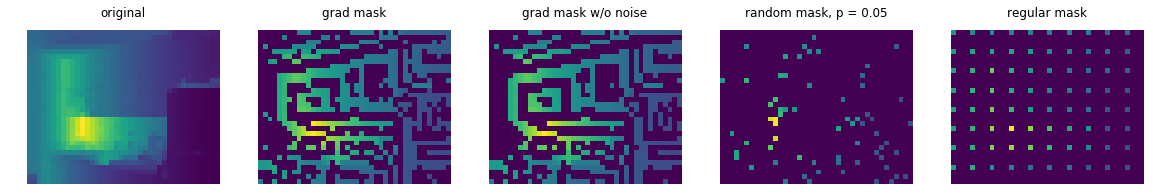

In [26]:
disp_downsampled = cv2.resize(nyu_d, tuple(reversed(small_size)))

rgbim_downsampled = cv2.resize(nyu_rgb,tuple(reversed(small_size)))

plot_different_masks(disp_downsampled, rgbim_downsampled, small_size)

grad_mask_small = get_grad_mask(rgbim_downsampled[None,...], tuple(small_size), combined=True, block_size = 5, constant = 11)
#grad_mask_small = get_grad_mask(rgbim_downsampled[None,...], tuple(small_size), combined=True)

grad_clean_mask_small = get_grad_mask(rgbim_downsampled[None,...], tuple(small_size), combined=False, block_size = 5,
                                      constant = 11)
pr = 0.1
random_mask_small = get_mask(tuple(small_size), pr)
regular_mask_small = get_regular_grid_mask(tuple(small_size), step = 4)

3.1654758 1.8181176 4.2192335
6.2450643 3.0787978 13.540799
1.764538 1.1245393 2.6057072
RMS =  0.6284152


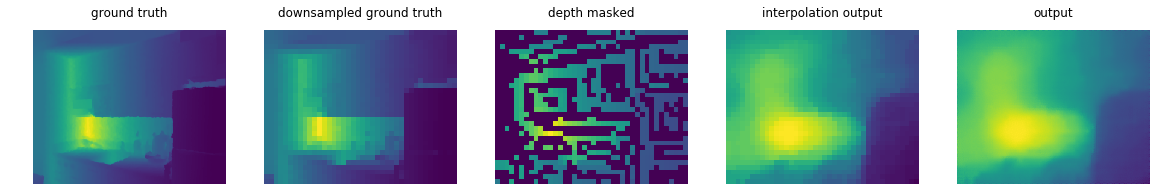

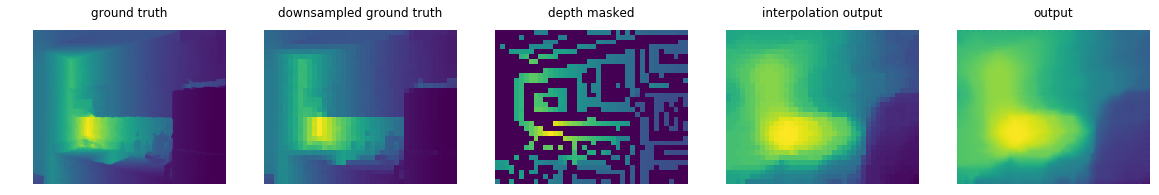

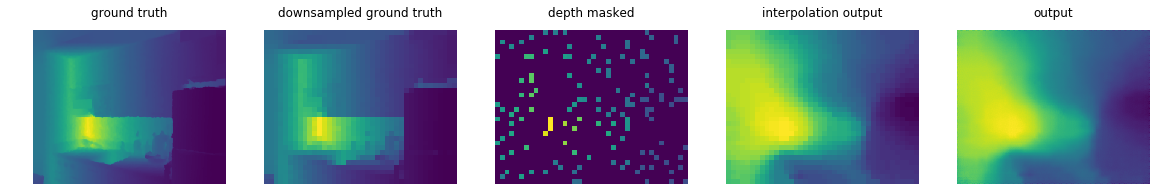

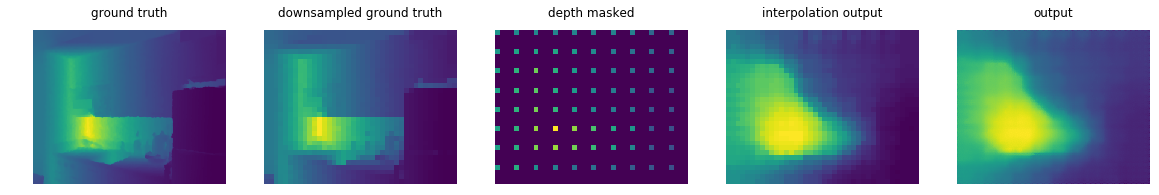

In [53]:

    
    
pred_interp , pred_sr = print_results(sess, G_output, G_output2, nyu_d, disp_downsampled,grad_mask_small)
print_results(sess, G_output, G_output2,nyu_d, disp_downsampled,grad_clean_mask_small)
print_results(sess, G_output, G_output2, nyu_d, disp_downsampled,random_mask_small)
print_results(sess, G_output, G_output2, nyu_d, disp_downsampled,regular_mask_small)
'''
print_results(disp_downsampled,grad_mask_small, 'grad.png')
print_results(disp_downsampled,grad_clean_mask_small, 'grad_rand.png')
print_results(disp_downsampled,random_mask_small, 'rand.png' )
print_results(disp_downsampled,regular_mask_small, 'grid.png')'''  



nyu_d_big = cv2.resize(nyu_d, tuple(reversed(big_size)))

print(np.mean(pred_sr), np.min(pred_sr),np.max(pred_sr))
print(np.mean(nyu_d_big) , np.min(nyu_d_big),np.max(nyu_d_big))
print(np.mean(np.log(nyu_d_big)) , np.min(np.log(nyu_d_big)),np.max(np.log(nyu_d_big)))

#print('RMS = ', np.sqrt(np.square(pred_sr[0,:,:,0] - (nyu_d_big))).mean())
print('RMS = ', np.sqrt(np.square(np.log(pred_sr[0,:,:,0]) - np.log((nyu_d_big)))).mean())
#print('RMS = ', np.sqrt(np.square(pred_sr[0,:,:,0] - np.log(nyu_d_big))).mean())


# Test on KITTI

In [11]:
velo_depth_dir = 'C:/Users/Dell/Documents/Jupyter/code/kitti/depth_selection/val_selection_cropped/velodyne_raw'
ground_truth_dir = 'C:/Users/Dell/Documents/Jupyter/code/kitti/depth_selection/val_selection_cropped/groundtruth_depth'

kitti_velo = read_depth.read_from_folder(velo_depth_dir)
kitti_gt = read_depth.read_from_folder(ground_truth_dir)

In [12]:
rbg_dir = 'C:/Users/Dell/Documents/Jupyter/code/kitti/depth_selection/val_selection_cropped/image'

kitti_rgb_filenames = [os.path.join(rbg_dir ,f) for f in os.listdir(rbg_dir )]
kitti_rgb = [ np.array(Image.open(image_path)).astype('float32') for image_path in kitti_rgb_filenames]

2011_09_26_drive_0002_sync_velodyne_raw_0000000026_image_03.png
C:/Users/Dell/Documents/Jupyter/code/kitti/depth_selection/val_selection_cropped/image\2011_09_26_drive_0002_sync_image_0000000026_image_03.png
0.0 78.19140625


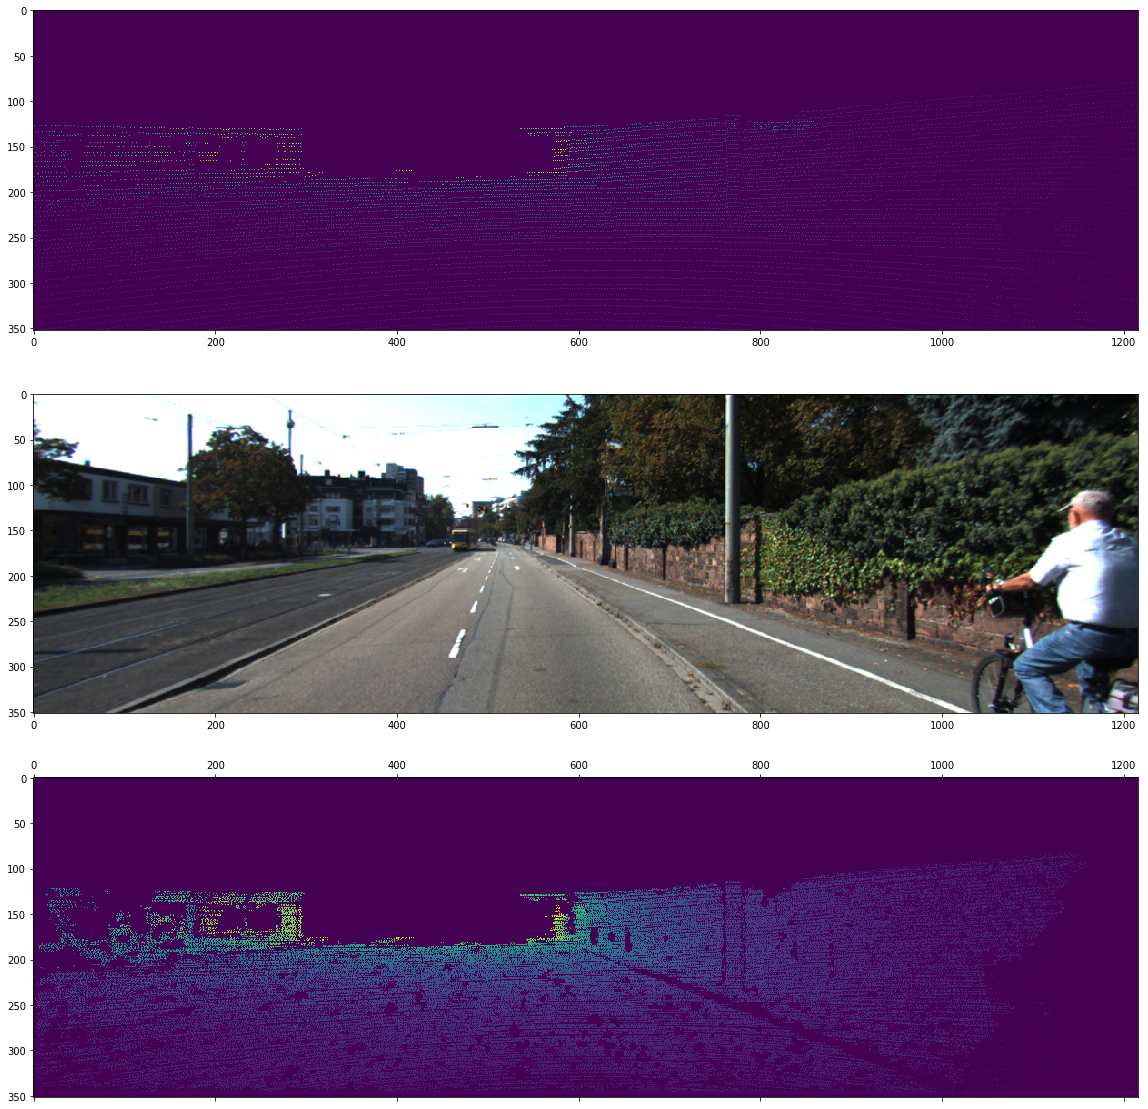

In [34]:
i = 7

print(os.listdir(velo_depth_dir)[i])
print(kitti_rgb_filenames[i])

test_img = kitti_velo[i]
print(test_img.min(), test_img.max())

test_img_rgb = kitti_rgb[i]

test_img_gt = kitti_gt[i]


fig, ax = plt.subplots(3,1,figsize = (20,20))
ax[0].imshow(test_img)
ax[1].imshow(test_img_rgb/255) #
ax[2].matshow(test_img_gt)

In [35]:
original_size = [test_img.shape[0],test_img.shape[1]]
print('KITTI original size = ', original_size)

downsample_factor = 8
upsample_factor = downsample_factor
small_size = (np.asarray(original_size)/downsample_factor)
small_size = (small_size/8).astype(int)*8 #make sure it is divisible by 8 (due to CNN architecture)
big_size = [small_size[0]*upsample_factor,small_size[1]*upsample_factor]

print('original_size = ', original_size)
print('small size = ', small_size)
print('big size = ', big_size)

KITTI original size =  [352, 1216]
original_size =  [352, 1216]
small size =  [ 40 152]
big size =  [320, 1216]


In [36]:
tf.reset_default_graph()
input_rgb, sparse, _, d_flg = interpolation_model.get_placeholders()
d_input, m = interpolation_model.preprocess_sparse_depth(sparse, small_size)
gr_input = interpolation_model.preprocess_rgb(input_rgb, small_size)
G_output =  interpolation_model.model(d_input, m, base_filters = 32,p=0.5, d_flg = False, use_bn = False)


d_small, d_flg2 = SR_model.get_placeholders()
d_input2, interpolated = SR_model.preprocess(d_small, big_size)
G_output2 = SR_model.model(d_small, interpolated, base_filters = 32,p = 0.8, d_flg = False)

all_vars = tf.global_variables()
interp_vars = [k for k in all_vars if k.name.startswith('G_Depth/')]
SR_vars = [k for k in all_vars if not  k.name.startswith('G_Depth/')]

sess = tf.InteractiveSession()   

tf.train.Saver(interp_vars).restore(sess, saved_models+ 'two_sec_vgg31_ps/model_34.ckpt')
tf.train.Saver(SR_vars).restore(sess, saved_models+'srres_ps/model.ckpt')

INFO:tensorflow:Restoring parameters from C:/Users/Dell/Documents/Experiments/deeplearning-semidense/out/two_sec_vgg31_ps/model_34.ckpt
INFO:tensorflow:Restoring parameters from C:/Users/Dell/Documents/Experiments/deeplearning-semidense/out/srres_ps/model.ckpt


c:\program files (x86)\python\python36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
c:\program files (x86)\python\python36\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\program files (x86)\python\python36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


0.0 0.7212190126117907 78.19140625
0.0 0.11394227135651003 4.359159747011144
0.8462157 1.2879286 2.0013053
0.0 3.750335164047314 83.21484375
0.0 0.6052587368394553 4.421425742370641


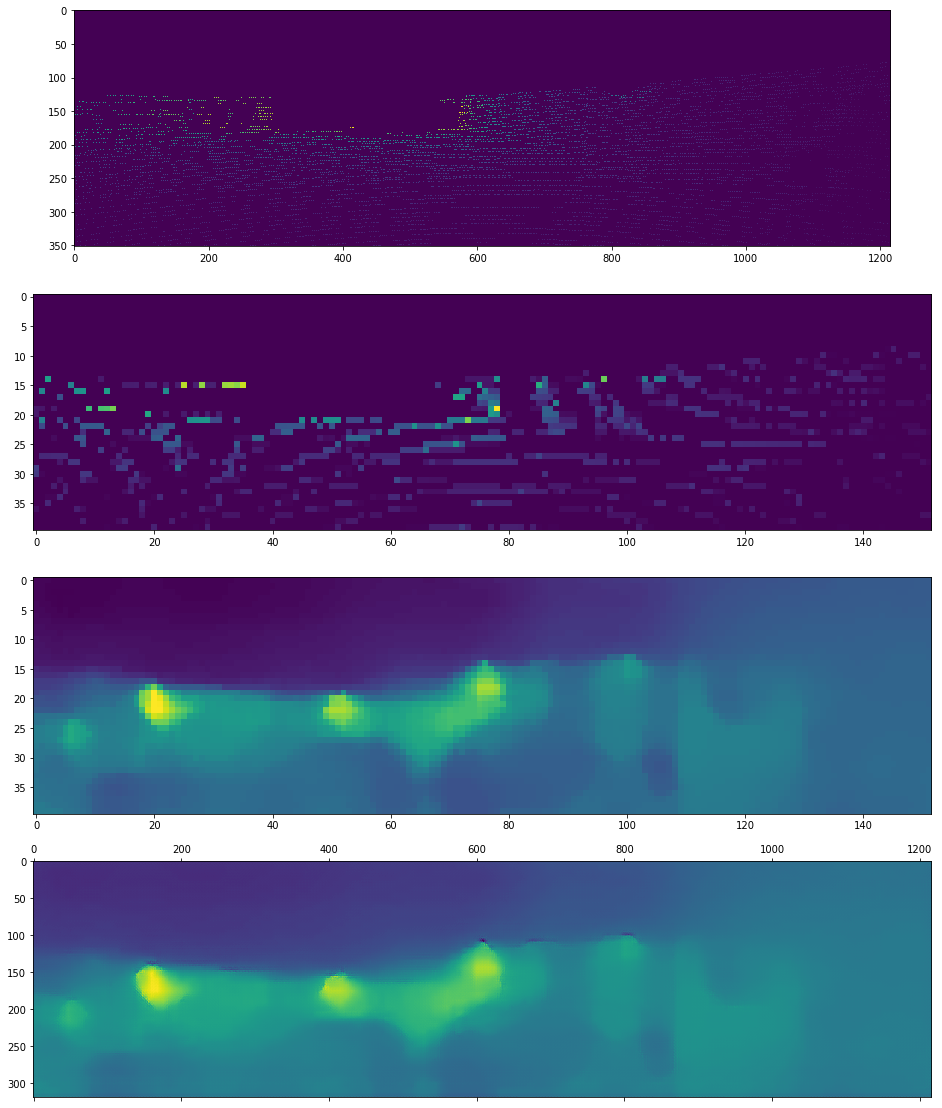

In [71]:
log_test_img = np.log(test_img)
log_test_img[test_img ==0] = 0

test_img_gt_big = resize(test_img_gt, big_size)

log_test_img_gt = np.log(test_img_gt)
log_test_img_gt[test_img_gt ==0] = 0

dense_interp,dense_sr = predict_sparse(sess, G_output, G_output2, log_test_img[None,...,None])


print(test_img.min(),test_img.mean(), test_img.max())
print(log_test_img.min(),log_test_img.mean(), log_test_img.max())
print(dense_sr[0,:,:,0].min(),dense_sr[0,:,:,0].mean(), dense_sr[0,:,:,0].max())
print(test_img_gt.min(),test_img_gt.mean(), test_img_gt.max())
print(log_test_img_gt.min(),log_test_img_gt.mean(), log_test_img_gt.max())



fig, ax = plt.subplots(4,1,figsize = (20,20))
ax[0].imshow(test_img)
ax[1].imshow(resize(test_img, small_size, preserve_range=True))
ax[2].imshow(dense_interp[0,:,:,0])
ax[3].matshow(dense_sr[0,:,:,0]) #

In [58]:
def kitti_gen(dd, sd):
    for d, s in zip(dd, sd):
        yield d[None,:,:,None], s[None,:,:,None]

## test on whole dataset

0it [00:00, ?it/s]c:\program files (x86)\python\python36\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
c:\program files (x86)\python\python36\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
c:\program files (x86)\python\python36\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
c:\program files (x86)\python\python36\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0.6004973216680315 0.0 4.373386622634416
2.6319275 1.7018936 4.1854215


1it [00:00,  2.56it/s]

0.5870271891036855 0.0 4.356077576936597
2.581298 1.6710577 4.440618


2it [00:00,  3.37it/s]

0.5960533059676465 0.0 4.390259254431959
2.5014796 1.5621152 4.198485


3it [00:00,  3.72it/s]

0.6107665779886879 0.0 4.364614559806643
2.4924383 1.3147101 4.2016206


4it [00:01,  3.90it/s]

0.6550836201359946 0.0 4.325239224591207
2.5327911 1.5298086 4.193529


5it [00:01,  4.07it/s]

0.5939967183104966 0.0 4.406402849469458
2.617202 1.7853076 4.2156777


6it [00:01,  4.21it/s]

0.617314298013814 0.0 4.374831544743474
2.613606 1.6621128 4.2763596


7it [00:01,  4.29it/s]

0.6051761560551944 0.0 4.347908673765806
2.6399572 1.8344598 4.397657


8it [00:01,  4.37it/s]

0.6869232754877758 0.0 4.385046945681255
2.6100297 1.6566397 4.243108


9it [00:02,  4.43it/s]

0.6539399423894858 0.0 4.368884341702094
2.5859993 1.9432696 4.1849675


10it [00:02,  4.48it/s]

0.7118147394243959 0.0 4.396703541973409
2.6131618 1.8388027 4.2128334


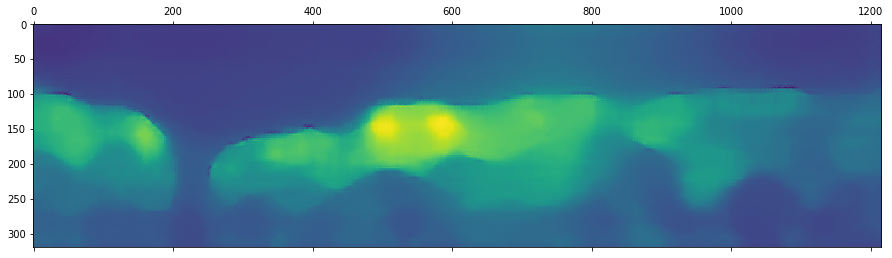

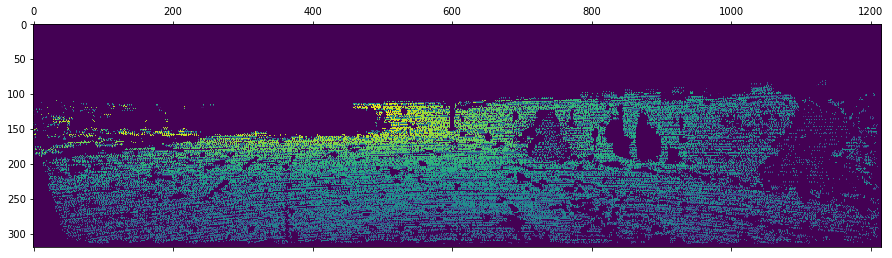

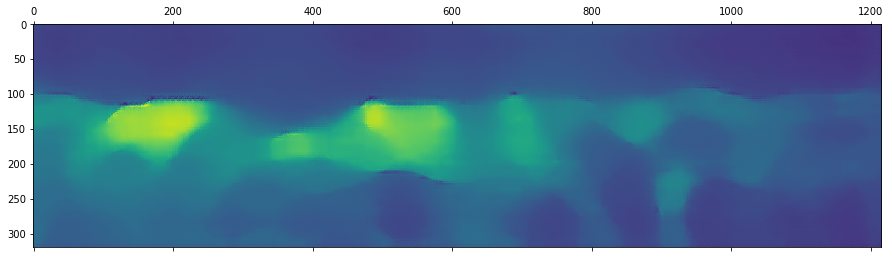

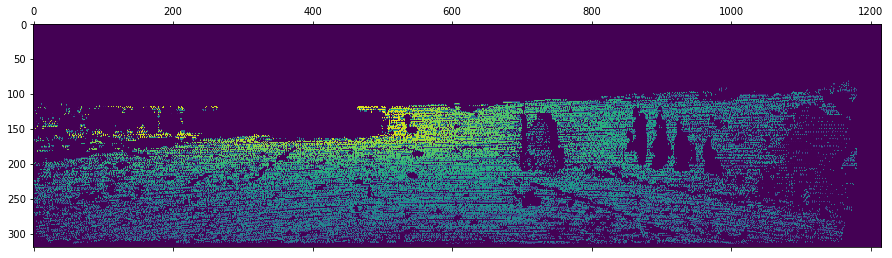

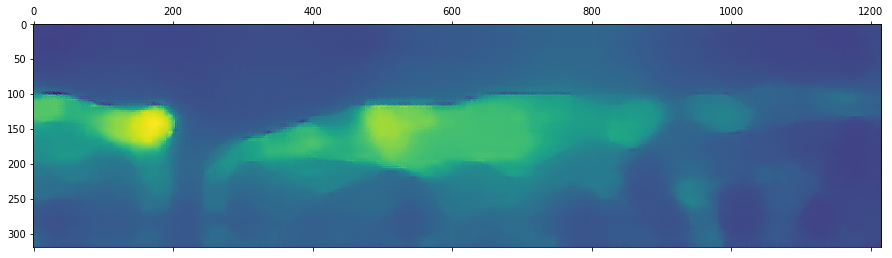

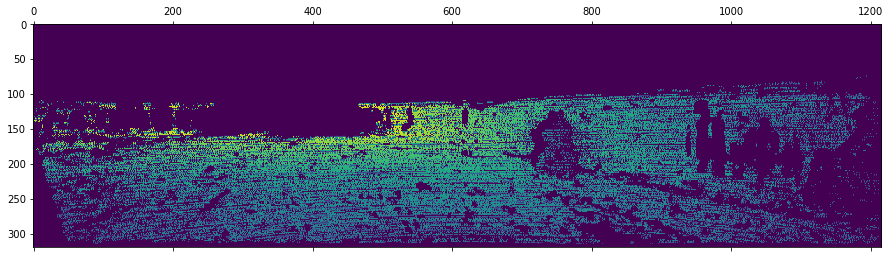

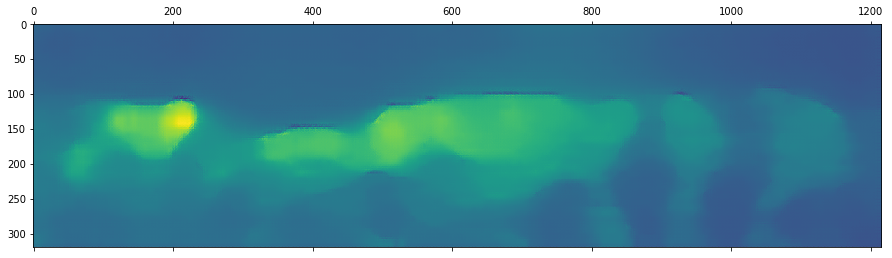

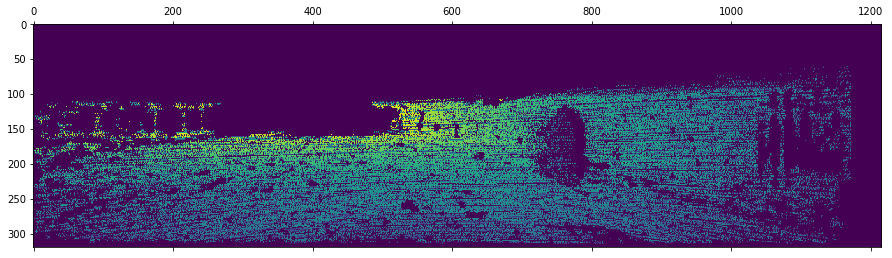

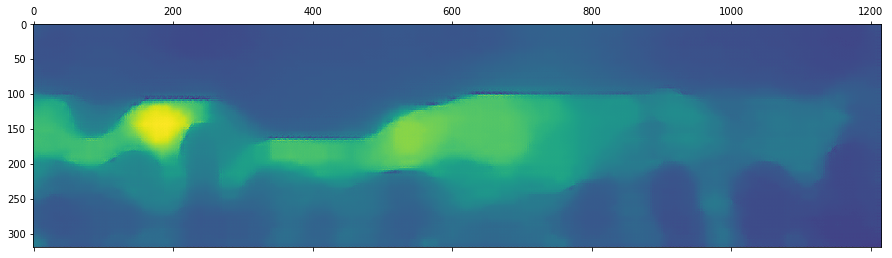

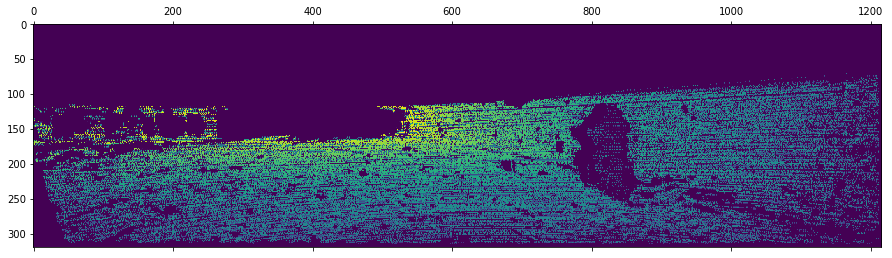

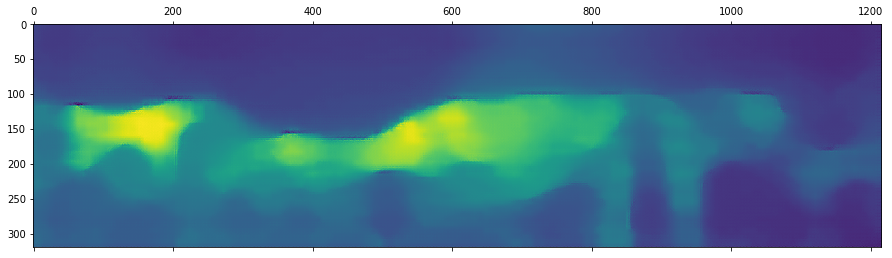

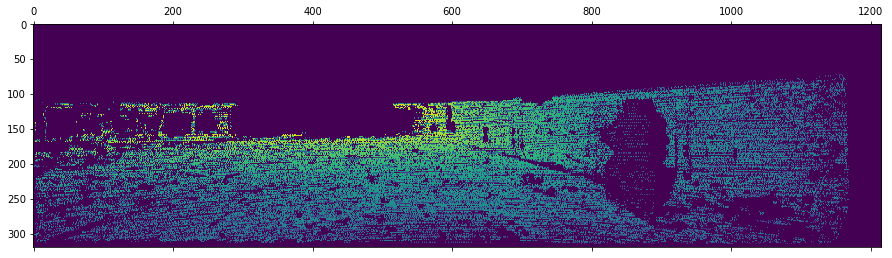

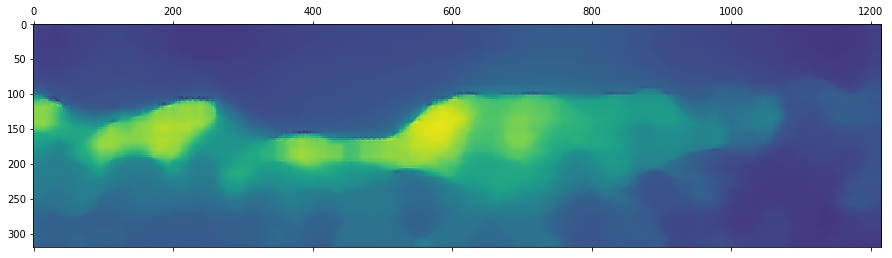

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


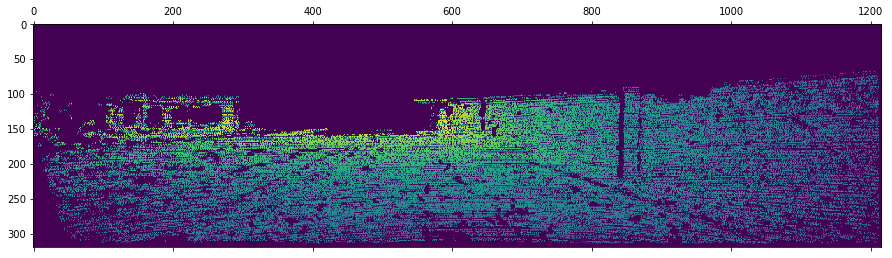

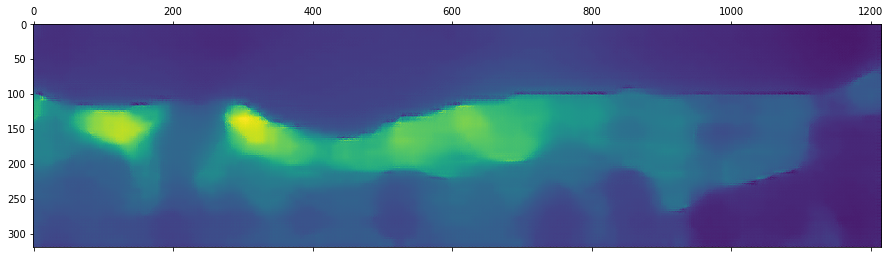

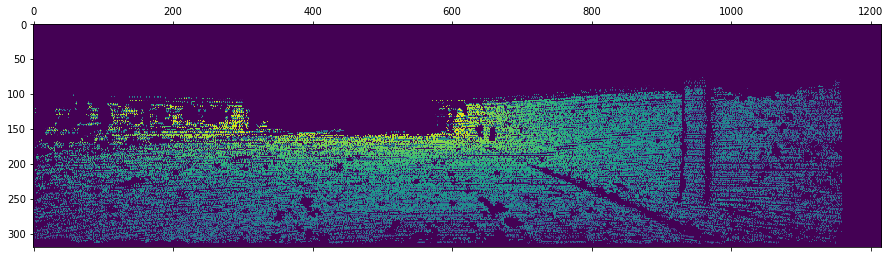

In [67]:
from tqdm import tqdm
bs = 1
iteration_num = 0
vals = []
rmse = []
ssim = []
times = []
for gt_b, yb in tqdm(kitti_gen(kitti_gt, kitti_velo )):    
    
    iteration_num +=1
    
    
    xb_small, yb_small = resize_batch(xb,yb,bs, small_size)
    
    log_yb_small = np.log(yb_small)
    log_yb_small[yb_small ==0] = 0
    
    
    start = time()
    _, out = predict_sparse(sess, G_output, G_output2,log_yb_small)
    times.append(time()-start)
    
    log_res_gt = np.zeros((bs, *big_size))
    
    log_gt = np.log(gt_b)
    log_gt[gt_b == 0] = 0
    
    for i in range(bs):
        log_gt = np.log(gt_b[i,:,:,0])
        log_gt[gt_b[i,:,:,0] == 0] = 0
        log_res_gt[i,:,:] = resize(log_gt, big_size, preserve_range=True)
        
        
    score = np.abs((out[:,:,:,0] - log_res_gt))/(log_res_gt + 1e-6)
    score = np.sum(score[log_res_gt>0])/np.sum(log_res_gt>0)
    
    score_rms = np.square((np.exp(out[:,:,:,0])) - np.exp(log_res_gt))
    score_rms = np.sqrt(np.sum(score_rms[log_res_gt>0])/np.sum(log_res_gt>0))
    

    print(np.mean(log_res_gt), np.min(log_res_gt), np.max(log_res_gt))
    print((np.mean(out)), (np.min(out)), (np.max(out)))
    
    """
    score_ssim = 0
    for i in range(len(out)):
        result = (out[i,:,:,0] - out[i,:,:,0].min())/(out[i,:,:,0].max() - out[i,:,:,0].min())
        result[res_gt[i]<=0] = 0
        res_gt[i] = np.log(res_gt[i] + 1e-8)
        gt = (res_gt[i] - res_gt[i].min())/(res_gt[i].max() - res_gt[i].min())
        score_ssim += compare_ssim(result.astype(np.float64), gt)
    score_ssim /= len(out)
    
    """
    if score < 1.1:
        #ssim.append(score_ssim)
        rmse.append(score_rms)
    #if score > 0.2:
        #print(score)
        #pict = np.zeros((synthia_size[0], synthia_size[1]*3))
        #for k in range(bs):
            #pict[:,0:synthia_size[1]] = mask[i,:,:,0]*res_gt[i]
            #pict[:,synthia_size[1]:synthia_size[1]*2] = out[i,:,:,0]
            #pict[:,synthia_size[1]*2:synthia_size[1]*3] = res_gt[i]
            #plt.figure()
            #plt.matshow(pict)
    vals.append(score)
    
    if iteration_num>10:
        break
        
    plt.matshow(out[0,:,:,0])
    plt.matshow(log_res_gt[0,:,:])

In [68]:
print(np.mean( vals))
print(np.mean(rmse))
print(np.mean(ssim))
print(np.mean(times))

354129.715268334


c:\program files (x86)\python\python36\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\program files (x86)\python\python36\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan
nan
0.04028214107860218


# Test on SYNTHIA

In [4]:
synthia_val = 'C:/Users/Dell/Documents/Experiments/SYNTHIA-SEQS-05-SPRING/'
synthia_size=[480,  640]

synthia_val_list = get_file_list(synthia_val)

synthia_depth_val = filter_files(synthia_val_list, ['Stereo_Left', 'Depth', 'png'])
synthia_rgb_val = filter_files(synthia_val_list, ['Stereo_Left', 'RGB', 'png'])

In [5]:
val_image_s = open_rgb(synthia_rgb_val[0])[None,:,:,:]
val_gt_s = open_depth_synthia(synthia_depth_val[0], debug=True)[None]
val_image_d = open_rgb(synthia_rgb_val[-1])[None,:,:,:]
val_gt_d = open_depth_synthia(synthia_depth_val[-1])[None,:,:,:]

grad_ms = get_grad_mask(val_image_s,synthia_size)
grad_md = get_grad_mask(val_image_d,synthia_size)
plt.matshow(get_grad_mask(val_image_s,synthia_size)[0,:,:,0])
plt.matshow(get_grad_mask(val_image_d,synthia_size)[0,:,:,0])
print(np.mean(grad_ms))
print(np.mean(grad_md))
print(val_image_d.shape)

(760, 1280)
uint16


NameError: name 'get_grad_mask' is not defined

In [11]:
original_size_ = [val_gt_s.shape[1],val_gt_s.shape[2]]
print('SINTHIA original size = ', original_size_)

print('...downsample originals...')
#original_size = [int((NYU_depth.shape[0]-crop[0])/2),int((NYU_depth.shape[1]-crop[1])/2)]
original_size = [synthia_size[0],synthia_size[1]]
downsample_factor = 8
upsample_factor = downsample_factor
small_size = (np.asarray(original_size)/downsample_factor)
small_size = (small_size/8).astype(int)*8 #make sure it is divisible by 8 (due to CNN architecture)
big_size = [small_size[0]*upsample_factor,small_size[1]*upsample_factor]

print('original_size = ', original_size)
print('small size = ', small_size)
print('big size = ', big_size)


SINTHIA original size =  [760, 1280]
...downsample originals...
original_size =  [480, 640]
small size =  [56 80]
big size =  [448, 640]


In [12]:
tf.reset_default_graph()
input_rgb, target,mask_t, d_flg = interpolation_model.get_placeholders()
y_true, d_input, m = interpolation_model.preprocess_depth(target, mask_t, small_size)
gr_input = interpolation_model.preprocess_rgb(input_rgb, small_size)
G_output =  interpolation_model.model(d_input, m, base_filters = 32,p=0.5, d_flg = False, use_bn = False)


d_small, d_flg2 = SR_model.get_placeholders()
d_input2, interpolated = SR_model.preprocess(d_small, big_size)
G_output2 = SR_model.model(d_small, interpolated, base_filters = 32,p = 0.8, d_flg = False)

all_vars = tf.global_variables()
interp_vars = [k for k in all_vars if k.name.startswith('G_Depth/')]
SR_vars = [k for k in all_vars if not  k.name.startswith('G_Depth/')]

sess = tf.InteractiveSession()   

tf.train.Saver(interp_vars).restore(sess, saved_models+ 'two_sec_vgg31_ps/model_34.ckpt')
tf.train.Saver(SR_vars).restore(sess, saved_models+'srres_ps/model.ckpt')

INFO:tensorflow:Restoring parameters from C:/Users/Dell/Documents/Experiments/deeplearning-semidense/out/two_sec_vgg31_ps/model_34.ckpt
INFO:tensorflow:Restoring parameters from C:/Users/Dell/Documents/Experiments/deeplearning-semidense/out/srres_ps/model.ckpt


### test on one Synthia image

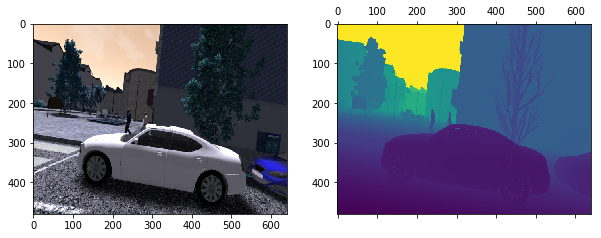

In [13]:
syn_rgb, syn_gt = resize_pair(val_image_d[0,:,:,:], val_gt_d[0,:,:,0], synthia_size)

fig, ax = plt.subplots(1,2,figsize = (10,10))
ax[0].imshow(syn_rgb/255)
ax[1].matshow(np.log(syn_gt))#.astype( np.uint8 )) #

mask sizes =  (1, 480, 640, 1) (1, 480, 640, 1)
mask sizes =  (1, 56, 80, 1) (1, 56, 80, 1)


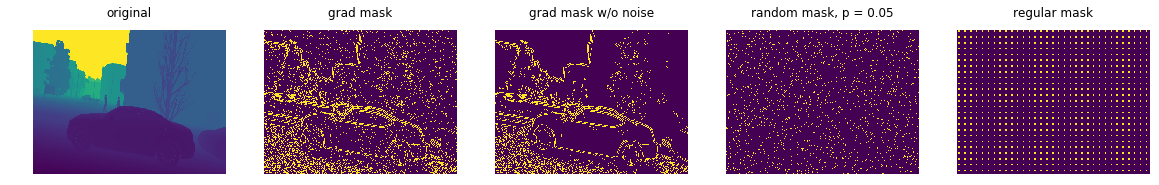

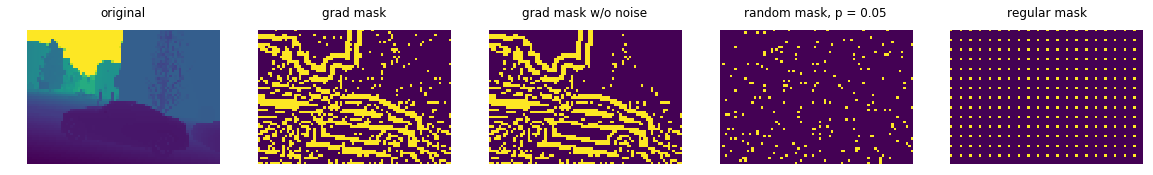

In [14]:
plot_different_masks(np.log(syn_gt), syn_rgb, original_size, False)

syn_gt_downsampled = cv2.resize(syn_gt, tuple(reversed(small_size)))
syn_rgb_downsampled = cv2.resize(syn_rgb,tuple(reversed(small_size)))

plot_different_masks(np.log(syn_gt_downsampled), syn_rgb_downsampled, small_size, False)

grad_mask_small = get_grad_mask(syn_rgb_downsampled[None,...], tuple(small_size), combined=True, block_size = 5, constant = 31)

grad_clean_mask_small = get_grad_mask(syn_rgb_downsampled[None,...], tuple(small_size), combined=False, block_size = 5,
                                      constant = 31)
pr = 0.1
random_mask_small = get_mask(tuple(small_size), pr)
regular_mask_small = get_regular_grid_mask(tuple(small_size), step = 4)


(480, 640) (1, 448, 640, 1)
1.2487649 0.22545767 2.7533693
76.027405 1.8703125 655.35
2.3974435 0.6261055 6.4851694
RMS =  1.7888753


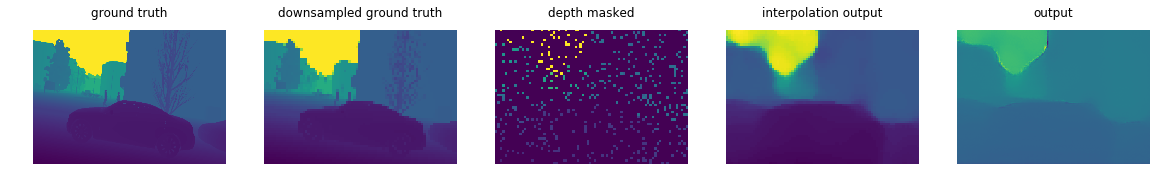

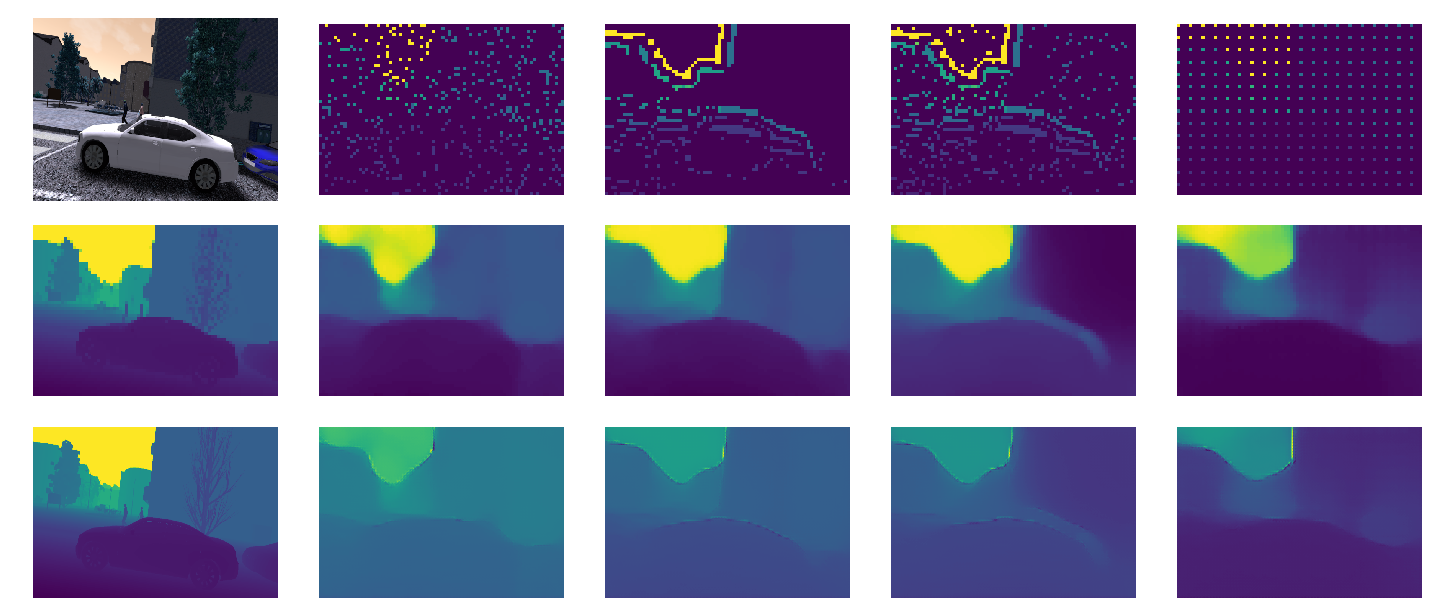

In [15]:
pred_interp, pred_sr = print_results(sess, G_output, G_output2, syn_gt, syn_gt_downsampled ,random_mask_small, name = 'syn_rand.png')
print(syn_gt.shape, pred_sr.shape)

syn_gt_big = cv2.resize(syn_gt, tuple(reversed(big_size)))

print(np.mean(pred_sr), np.min(pred_sr),np.max(pred_sr))
print(np.mean(syn_gt_big) , np.min(syn_gt_big),np.max(syn_gt_big))
print(np.mean(np.log(syn_gt_big)) , np.min(np.log(syn_gt_big)),np.max(np.log(syn_gt_big)))

print('RMS = ', np.sqrt(np.square((pred_sr[0,:,:,0] - np.log(syn_gt_big))).mean()))

predictions = []
predictions.append((pred_interp, pred_sr))

predictions.append(predict(sess, G_output, G_output2,syn_gt_downsampled[None,...,None], grad_mask_small))
predictions.append(predict(sess, G_output, G_output2,syn_gt_downsampled[None,...,None], grad_clean_mask_small))
predictions.append(predict(sess, G_output, G_output2,syn_gt_downsampled[None,...,None], regular_mask_small))

fig, ax = plt.subplots(3,5,figsize = (20,9))
fig.tight_layout()
fig.subplots_adjust(hspace = 0.001)
ax[0,0].imshow(syn_rgb/255, interpolation='nearest')
ax[0,1].matshow(np.log(syn_gt_downsampled)*random_mask_small[0,:,:,0]) #
ax[0,2].matshow(np.log(syn_gt_downsampled)*grad_clean_mask_small[0,:,:,0])
ax[0,3].matshow(np.log(syn_gt_downsampled)*grad_mask_small[0,:,:,0])
ax[0,4].matshow(np.log(syn_gt_downsampled)*regular_mask_small[0,:,:,0])
ax[1,0].matshow(np.log(syn_gt_downsampled)) #
ax[1,1].matshow(predictions[0][0][0,:,:,0]) #
ax[1,2].matshow(predictions[1][0][0,:,:,0])
ax[1,3].matshow(predictions[2][0][0,:,:,0])
ax[1,4].matshow(predictions[3][0][0,:,:,0])
ax[2,0].matshow(np.log(syn_gt_big)) #
ax[2,1].matshow(predictions[0][1][0,:,:,0]) #
ax[2,2].matshow(predictions[1][1][0,:,:,0])
ax[2,3].matshow(predictions[2][1][0,:,:,0])
ax[2,4].matshow(predictions[3][1][0,:,:,0])

for (x,y), value in np.ndenumerate(ax):
    ax[x,y].axis('off')

"""
pred_interp, pred_sr = print_results(sess, G_output, G_output2, syn_gt, syn_gt_downsampled ,grad_mask_small, 'syn_grad.png', False)
pred_interp, pred_sr = print_results(sess, G_output, G_output2, syn_gt, syn_gt_downsampled ,grad_clean_mask_small,  'syn_grad_clean.png', False)
pred_interp, pred_sr = print_results(sess, G_output, G_output2, syn_gt, syn_gt_downsampled ,regular_mask_small,  'syn_reg.png', False)
"""


plt.savefig('syn_compare.png')


In [16]:
from tqdm import tqdm
bs = 5
val_loss_l1 = 0
val_loss_l2 = 0
val_b = len(synthia_rgb_val)/bs
batch_it = tqdm(SynthiaIterator(synthia_rgb_val, synthia_depth_val, 
                                batchsize=bs, 
                                shuffle=True, 
                                buffer_size = 70), 
                total=val_b, 
                leave=False)
vals = []
rmse = []
ssim = []
times = []
for xb, yb in batch_it:    
    xb_small, yb_small = resize_batch(xb,yb,bs, small_size)
    
    maskb = get_grad_mask(xb_small, small_size,combined=True, block_size = 3, constant = 21)
    
    #maskb = get_grad_mask(xb_small, small_size,combined=False, block_size = 3, constant = 21)
    
    #z = np.zeros((1, * small_size, 1))
    #z[:,::7,::7,:] = 1
    #maskb = np.concatenate([z]*bs)
    
    #maskb =  np.concatenate([get_mask(small_size, 0.1)]*bs)
    
    start = time()
    _, out = predict(sess, G_output, G_output2,yb_small,maskb)
    times.append(time()-start)
    
    res_gt = np.zeros((bs, *big_size))
    
    for i in range(bs):
        res_gt[i,:,:] = resize(np.log(yb[i,:,:,0]), big_size, preserve_range=True)
        
    score = np.abs((out[:,:,:,0] - res_gt)/(res_gt + 1e-6)).mean()
    score_rms = np.sqrt(np.square(np.exp(out[:,:,:,0]) - np.exp(res_gt)).mean())
    score_ssim = 0
    for i in range(len(out)):
        result = (out[i,:,:,0] - out[i,:,:,0].min())/(out[i,:,:,0].max() - out[i,:,:,0].min())
        gt = (res_gt[i] - res_gt[i].min())/(res_gt[i].max() - res_gt[i].min())

        score_ssim += compare_ssim(result.astype(np.float64), gt)
    score_ssim /= len(out)
    if score < 1.1:
        ssim.append(score_ssim)
        rmse.append(score_rms)
    #if score > 0.2:
        #print(score)
        #pict = np.zeros((synthia_size[0], synthia_size[1]*3))
        #for k in range(bs):
            #pict[:,0:synthia_size[1]] = mask[i,:,:,0]*res_gt[i]
            #pict[:,synthia_size[1]:synthia_size[1]*2] = out[i,:,:,0]
            #pict[:,synthia_size[1]*2:synthia_size[1]*3] = res_gt[i]
            #plt.figure()
            #plt.matshow(pict)
    vals.append(score)


  0%|                                                                                        | 0/236.0 [00:00<?, ?it/s]c:\program files (x86)\python\python36\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [17]:
print(np.mean( vals))
print(np.mean(rmse))
print(np.mean(ssim))
print(np.mean(times))

0.4178933041372025
275.474908758714
0.7550007632271789
0.06092072644476163


In [27]:
"""
#image saving................................................................
for i in test_inds:
    rgb, d = get_nyu_rgbd_pair(i)
    #rgb, d = crop(rgb, d, [12,14])
    #rgb, d = resize(rgb, d,[240,320])
    
    Image.fromarray(rgb).save("test_images/nyu" +str(i)+".png")
    #Rescale to 0-255 and convert to uint8
    nyu_d_rescaled = (255.0 / d.max() * (d - d.min())).astype(np.uint8)
    Image.fromarray(nyu_d_rescaled).save("test_images/depth/nyu" +str(i)+"_d.png", "PNG")
    
"""

'\n#image saving................................................................\nfor i in test_inds:\n    rgb, d = get_nyu_rgbd_pair(i)\n    #rgb, d = crop(rgb, d, [12,14])\n    #rgb, d = resize(rgb, d,[240,320])\n    \n    Image.fromarray(rgb).save("test_images/nyu" +str(i)+".png")\n    #Rescale to 0-255 and convert to uint8\n    nyu_d_rescaled = (255.0 / d.max() * (d - d.min())).astype(np.uint8)\n    Image.fromarray(nyu_d_rescaled).save("test_images/depth/nyu" +str(i)+"_d.png", "PNG")\n    \n'

0 C:\Users\Dell\Documents\Jupyter\code/others\eigen_nuy1_d.png
1 C:\Users\Dell\Documents\Jupyter\code/others\grad.png
2 C:\Users\Dell\Documents\Jupyter\code/others\grad_rand.png
3 C:\Users\Dell\Documents\Jupyter\code/others\grid.png
4 C:\Users\Dell\Documents\Jupyter\code/others\laina_nuy1_d.png
5 C:\Users\Dell\Documents\Jupyter\code/others\nyu1.png
6 C:\Users\Dell\Documents\Jupyter\code/others\nyu1_d.png
7 C:\Users\Dell\Documents\Jupyter\code/others\rand.png


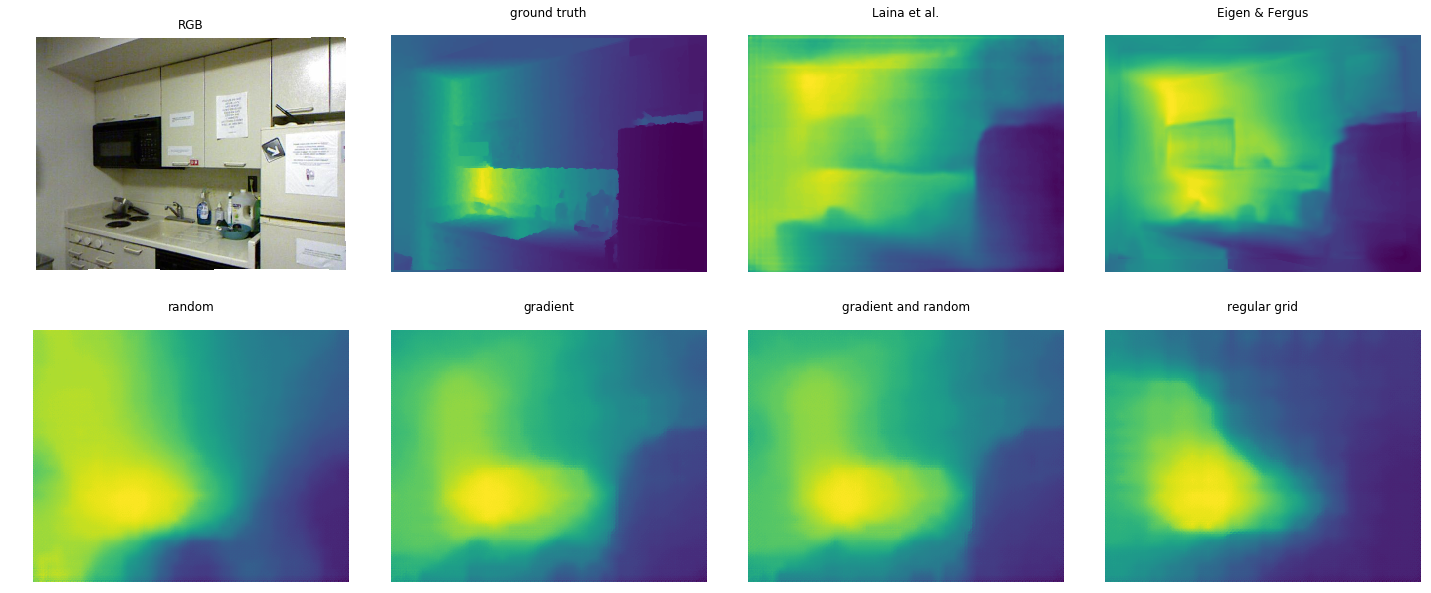

In [67]:

img_dir = os.getcwd() + '/others'
example_images = [os.path.join(img_dir,f) for f in os.listdir(img_dir) if '.png' in f]
for i in range(len(example_images)):
    print(i, example_images[i])

def read_from_file(image_path):
    img = Image.open(image_path)
    return np.array(img)#.astype('float32')


fig, ax = plt.subplots(2,4,figsize = (20,9))
fig.tight_layout()
fig.subplots_adjust(hspace = 0.001)
ax[0,0].imshow(read_from_file(example_images[5])), ax[0,0].set_title("RGB"), ax[0,0].axis('off')
ax[0,1].matshow(read_from_file(example_images[6])), ax[0,1].set_title("ground truth"), ax[0,1].axis('off')
ax[0,2].matshow(read_from_file(example_images[4])), ax[0,2].set_title("Laina et al."), ax[0,2].axis('off')
ax[0,3].matshow(read_from_file(example_images[0])), ax[0,3].set_title("Eigen & Fergus"), ax[0,3].axis('off')
ax[1,0].matshow(read_from_file(example_images[7])), ax[1,0].set_title("random"), ax[1,0].axis('off')
ax[1,1].matshow(read_from_file(example_images[1])), ax[1,1].set_title("gradient"), ax[1,1].axis('off')
ax[1,2].matshow(read_from_file(example_images[2])), ax[1,2].set_title("gradient and random"), ax[1,2].axis('off')
ax[1,3].matshow(read_from_file(example_images[3])), ax[1,3].set_title("regular grid"), ax[1,3].axis('off')

plt.savefig('res.png')